# Initializer
Import and initialize libraries to be used

In [1]:
# jupyter magic to show graphs in the notebook
%config InlineBackend.rc = {'figure.figsize' : (10, 5) }
%matplotlib inline
import re              # library for regular expressions
import logging         # library to prin interpretable log messages
import numpy as np     # library to process numeric data
import matplotlib.pyplot as plt   # python's answer to plotting
import pandas as pd    # library to read, organize and manipulate data
from fuzzywuzzy import fuzz # string matching library using Levenshtein Distance 
import ipywidgets      # library to use interactive widgets in jupyter notebook
import multiprocessing as mp # library for parallel processing to speed things up
import seaborn as sns
from functools import partial

# import plotly as pltly # convert matplotlib plots to interactive graphs
# pltly.offline.enable_mpl_offline(resize=True, show_link=False) # make interactive graphs render offline

# setup logging configuration
logging.basicConfig(format='%(asctime)s.%(msecs)03d; %(levelname)s; %(funcName)s:%(lineno)d; %(message)s', 
                    level=logging.DEBUG, datefmt='%Y-%m-%d %H:%M:%S')

2018-03-28 17:49:36.933; DEBUG; pylab_setup:90; backend module://ipykernel.pylab.backend_inline version unknown


# Read raw data
Retrieve raw data in CSV to pandas dataframes.

## Attempt manual reading of CSV

In [2]:
with open('data_in/DBLP1.csv', 'rb') as fp:
    line_bytes = fp.readline()
    line_str = line_bytes.decode('utf-8','replace') # this line is able to replace unicode with accented characters

## Split the string sequence into individual lines and create pandas dataframe
The first line is the column names. 

In [3]:
lines = line_str.splitlines()

In [4]:
line = lines[0]
print(line.split(','))

['idDBLP', 'title', 'authors', 'venue', 'year', 'Row_ID']


Now we have each line of the CSV containing column values separated by `,` character. We can now use the `.split` operation on the strings to extract all the characters separated by comma. However, the list of authors also comtains commas and cannot be directly applied. There is, however, a pattern in the list of authors which is that the list of authors is usually enclosed within double-quotes (`"`). This list of strings within the double quotes will mean that they be joined together to form a single column. The final check condition is that the number of extracted elements from each row should be equal to the total number of columns in the dataset. This is also true in cases where the long text is enclosed within the double-quotes.

In [5]:
columns = lines[0].split(',')
df = pd.DataFrame(columns=columns)

In [6]:
count = 0       # this is for debugging purposes
for line in lines[1:]:    
    count += 1     # this commented block was used to test the loop for small data samples
#     if count > 10:
#         break

    row = line.split(',')   # extract all comma-separated sub-strings
    start_author = False    # marker for start and end of joining the list of authors
    to_remove = []          # list to hold the indexes to be removed from the row
    for i in range(len(row)):   # for each comma sub-string
        if start_author:        # if a list-of authors is found
            row[start_author] = row[start_author] + ',' + row[i] # append the substring to first author
            to_remove.append(i)    # mark this index to be removed
        if row[i][0] == '"':       # if first character is a double-quote
            start_author = i       # mark this index 
        if row[i][-1] == '"':      # if last character is a double-quote
            start_author = False   # mark done-appending authors list
    
    # create new list `row2` to be used to append to dataframe
    if len(to_remove) == 0:      # if nothing to remove
        row2 = row
    else:                        # some elements marked to remove
        row2 = []
        for i in range(len(row)): # create `row2` with accepted index elements 
            if i in to_remove:
                continue
            row2.append(row[i])

    if len(row2) != len(columns):   # sanity check
        logging.error('{}: {} != {}\t {}'.format(count, len(row2), len(columns), row2))
        break
    
#     logging.info(line)
#     logging.info(row)
#     logging.info(row2)
#     logging.info('row length = {}'.format(len(row2)))
#     logging.info('-----------')
    
    d = dict()                                  # create a temporary dictionary element 
    for idx, col in enumerate(columns):         # 
        d[col] = row2[idx]
    df = df.append(d, ignore_index=True)

In [7]:
df.head()

idDBLP  \
0  conf/vldb/RusinkiewiczKTWM95   
1  journals/sigmod/EisenbergM02   
2          conf/vldb/AmmannJR95   
3         journals/sigmod/Liu02   
4      journals/sigmod/Hammer02   

                                               title  \
0  Towards a Cooperative Transaction Model - The ...   
1                    SQL/XML is Making Good Progress   
2  Using Formal Methods to Reason about Semantics...   
3                                     Editor's Notes   
4  Report on the ACM Fourth International Worksho...   

                                             authors          venue  year  \
0  "M Rusinkiewicz, W Klas, T Tesch, J W�sch, P M...           VLDB  1995   
1                            "A Eisenberg, J Melton"  SIGMOD Record  2002   
2                       "P Ammann, S Jajodia, I Ray"           VLDB  1995   
3                                              L Liu  SIGMOD Record  2002   
4                                                N/A            N/A  2002   

  Row_ID  
0      1  
1      2  
2      3  
3      4  
4      5

## Consolidate above method into a helper function
This function will take the CSV file path as an argument, read, extract and parse the data to a pandas dataframe and return it as the output.

In [8]:
def read_csv(file_path):
    # from 2.2 above
    with open(file_path, 'rb') as fp:
        line_bytes = fp.readline()
        line_str = line_bytes.decode('utf-8','replace') # this line is able to replace unicode with accented characters
    
    # from 2.3 above
    lines = line_str.splitlines()
    
    columns = lines[0].split(',')
    df = pd.DataFrame(columns=columns)
    
    count = 0       # this is for debugging purposes
    for line in lines[1:]:    
        count += 1     # this commented block was used to test the loop for small data samples
    #     if count > 10:
    #         break

        row = line.split(',')   # extract all comma-separated sub-strings
        start_author = False    # marker for start and end of joining the list of authors
        to_remove = []          # list to hold the indexes to be removed from the row
        for i in range(len(row)):   # for each comma sub-string
            if start_author:        # if a list-of authors is found
                row[start_author] = row[start_author] + ',' + row[i] # append the substring to first author
                to_remove.append(i)    # mark this index to be removed
            if len(row[i]) == 0:       # sanity check
                continue
            if row[i][0] == '"':       # if first character is a double-quote
                start_author = i       # mark this index 
            if row[i][-1] == '"':      # if last character is a double-quote
                start_author = False   # mark done-appending authors list

        # create new list `row2` to be used to append to dataframe
        if len(to_remove) == 0:      # if nothing to remove
            row2 = row
        else:                        # some elements marked to remove
            row2 = []
            for i in range(len(row)): # create `row2` with accepted index elements 
                if i in to_remove:
                    continue
                row2.append(row[i])

        if len(row2) != len(columns):   # sanity check
            logging.error('{}: {} != {}\t {}'.format(count, len(row2), len(columns), row2))
            break

    #     logging.info(line)
    #     logging.info(row)
    #     logging.info(row2)
    #     logging.info('row length = {}'.format(len(row2)))
    #     logging.info('-----------')

        d = dict()                                  # create a temporary dictionary element 
        for idx, col in enumerate(columns):         # 
            d[col] = row2[idx]
        df = df.append(d, ignore_index=True)

    return df

In [9]:
dblp = read_csv('data_in/DBLP1.csv')
scholar = read_csv('data_in/Scholar.csv')

2018-03-28 17:49:51.783; ERROR; read_csv:44; 101: 11 != 6	 ['kI-Hiv-7NZsJ', 'Gastroenteritis due to Kanagawa negative Vibrio parahaemolyticus', '"', ' I Goto', ' I Minematsu', ' N Ikeda', ' N Asano', ' M  "', '"Lancet i,"', '1987', '101']


In [10]:
dblp.head()

idDBLP  \
0  conf/vldb/RusinkiewiczKTWM95   
1  journals/sigmod/EisenbergM02   
2          conf/vldb/AmmannJR95   
3         journals/sigmod/Liu02   
4      journals/sigmod/Hammer02   

                                               title  \
0  Towards a Cooperative Transaction Model - The ...   
1                    SQL/XML is Making Good Progress   
2  Using Formal Methods to Reason about Semantics...   
3                                     Editor's Notes   
4  Report on the ACM Fourth International Worksho...   

                                             authors          venue  year  \
0  "M Rusinkiewicz, W Klas, T Tesch, J W�sch, P M...           VLDB  1995   
1                            "A Eisenberg, J Melton"  SIGMOD Record  2002   
2                       "P Ammann, S Jajodia, I Ray"           VLDB  1995   
3                                              L Liu  SIGMOD Record  2002   
4                                                N/A            N/A  2002   

  Row_ID  
0      1  
1      2  
2      3  
3      4  
4      5

In [11]:
scholar.head()

idScholar                                              title  \
0  aKcZKwvwbQwJ                         11578 Sorrento Valley Road   
1  ixKfiTHoaDoJ                Initiation of crazes in polystyrene   
2  3BxllB4wwcIJ  Immunogold labelling is a quantitative method ...   
3  d2WWxwKMex4J  The Burden of Infectious Disease Among Inmates...   
4  cZCX-AQpjccJ  The Role of Faculty Advising in Science and En...   

                                             authors  \
0                                             QD Inc   
1                            "AS Argon, JG Hannoosh"   
2  "GH Hansen, LL Wetterberg, H Sj퀌_str퀌_m, O Nor...   
3                   "TM Hammett, P Harmon, W Rhodes"   
4                                         JR Cogdell   

                                         venue  year ROW_ID  
0                                 "San Diego,"            1  
1                                 "Phil. Mag,"            2  
2                 "The Histochemical Journal,"  1992      3  
3                                          see            4  
4  "NEW DIRECTIONS FOR TEACHING AND LEARNING,"  1995      5

## Attempt lazy loading using `pandas.read_csv` function

In [12]:
try: 
    dblp = pd.read_csv('data_in/DBLP1.csv', encoding='utf-8', header=0, )
#     scholar = pd.read_csv('data_in/Scholar.csv')
except Exception as e:
    logging.error(e)

2018-03-28 17:49:51.852; ERROR; <module>:5; 'utf-8' codec can't decode byte 0x92 in position 3: invalid start byte


Note that the above attempt has failed presenting errors in the encoded format of the CSV file. We will now have to open the file and parse individual lines. To do so, I will be reading one line at a time and verify the output using the above approach. Manually reading the CSV file also showed the newline character to be the `\r` i.e., carriage return instead of the universal `\n` or `\r\n`.

In [13]:
try: 
    dblp = pd.read_csv('data_in/DBLP1.csv', encoding='iso8859_15', header=0, engine='python')
    scholar = pd.read_csv('data_in/Scholar.csv', encoding='iso8859_15', engine='python')
except Exception as e:
    logging.error(e)

In [14]:
dblp.head()

idDBLP  \
0  conf/vldb/RusinkiewiczKTWM95   
1  journals/sigmod/EisenbergM02   
2          conf/vldb/AmmannJR95   
3         journals/sigmod/Liu02   
4      journals/sigmod/Hammer02   

                                               title  \
0  Towards a Cooperative Transaction Model - The ...   
1                    SQL/XML is Making Good Progress   
2  Using Formal Methods to Reason about Semantics...   
3                                     Editor's Notes   
4  Report on the ACM Fourth International Worksho...   

                                            authors          venue  year  \
0  M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth           VLDB  1995   
1                             A Eisenberg, J Melton  SIGMOD Record  2002   
2                        P Ammann, S Jajodia, I Ray           VLDB  1995   
3                                             L Liu  SIGMOD Record  2002   
4                                               NaN            NaN  2002   

   Row_ID  
0       1  
1       2  
2       3  
3       4  
4       5

In [15]:
scholar.head()

idScholar                                              title  \
0  aKcZKwvwbQwJ                         11578 Sorrento Valley Road   
1  ixKfiTHoaDoJ                Initiation of crazes in polystyrene   
2  3BxllB4wwcIJ  Immunogold labelling is a quantitative method ...   
3  d2WWxwKMex4J  The Burden of Infectious Disease Among Inmates...   
4  cZCX-AQpjccJ  The Role of Faculty Advising in Science and En...   

                                             authors  \
0                                             QD Inc   
1                              AS Argon, JG Hannoosh   
2  GH Hansen, LL Wetterberg, H Sjí_strí_m, O ...   
3                     TM Hammett, P Harmon, W Rhodes   
4                                         JR Cogdell   

                                       venue    year  ROW_ID  
0                                 San Diego,     NaN       1  
1                                 Phil. Mag,     NaN       2  
2                 The Histochemical Journal,  1992.0       3  
3                                        see     NaN       4  
4  NEW DIRECTIONS FOR TEACHING AND LEARNING,  1995.0       5

Notice that this approach using pandas is much faster but there are inconsistencies in the Unicode text between the two approaches.
We can proceed using either approaches.

# Finding matches
We will do a two-pass approach. In each pass, we iterate through the rows of dataframe and find any match in the other dataframe. The first approximation for a match is the `title` field. Note the inconsistencies in text cases. for synchronization, we will create a lower-case column for comparison.

In [16]:
# example
display(dblp.head(1))
ex_title = dblp.loc[0,'title']    # get title of first row in dblp
print('**Searching for title:** ' + ex_title)
scholar.loc[scholar.title.str.contains(ex_title, case=False)]  # search for that title in scholar

idDBLP  \
0  conf/vldb/RusinkiewiczKTWM95   

                                               title  \
0  Towards a Cooperative Transaction Model - The ...   

                                            authors venue  year  Row_ID  
0  M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth  VLDB  1995       1

**Searching for title:** Towards a Cooperative Transaction Model - The Cooperative Activity Model


Empty DataFrame
Columns: [idScholar, title, authors, venue, year, ROW_ID]
Index: []

This has returned **0** results. However, if we search for only parts of the text as below:

In [17]:
scholar.loc[scholar.title.str.contains('Towards a Cooperative Transaction Model', case=False)]  # search for that title in scholar

idScholar                                              title  \
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   
59993  iWNLOYCQX-YJ  W asch, J., Muth, P.: Towards a cooperative tr...   

                                                 authors  \
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   
59993                    M Rusinkiewicz, W Klas, T Tesch   

                                                   venue    year  ROW_ID  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547  
59993  Proc. ofthe 21 stInternational Conference on V...     NaN   59994

It is very clear to see that there are a lot of inconsistencies. The obvious one here being that in scholar database, there are no spaces before and after the hyphen `-` in the title leading to no results before. We can address this by manually ensuring that is exactly one space before and exactly one space after the hyphen. However, this manual approach may not address all the issues in the unclean data. 

Since the objective here is to find matches between the two dataframes, we can check the probabilities of matches.

## Approach 1 - Probability of matching words
This is a fairly straight forward approach in which individual words are extracted from the title to be searched. Words that are two characters or smaller are rejected. The remaining words are used to compute the probability of existance in the other dataframe. The probability is computed as:
$$P = \frac{\text{number of matches observed}}{\text{number of words searched}}$$
Since all the words should match, we will set a threshold of `1.0` to accept the matches

['Towards', 'a', 'Cooperative', 'Transaction', 'Model', '-', 'The', 'Cooperative', 'Activity', 'Model']
['Towards', 'Cooperative', 'Transaction', 'Model', 'The', 'Cooperative', 'Activity', 'Model']
Matches found at:


idScholar                                              title  \
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   
59993  iWNLOYCQX-YJ  W asch, J., Muth, P.: Towards a cooperative tr...   

                                                 authors  \
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   
59993                    M Rusinkiewicz, W Klas, T Tesch   

                                                   venue    year  ROW_ID  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547  
59993  Proc. ofthe 21 stInternational Conference on V...     NaN   59994

2018-03-28 17:49:53.532; DEBUG; findfont:1343; findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/kvedala/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


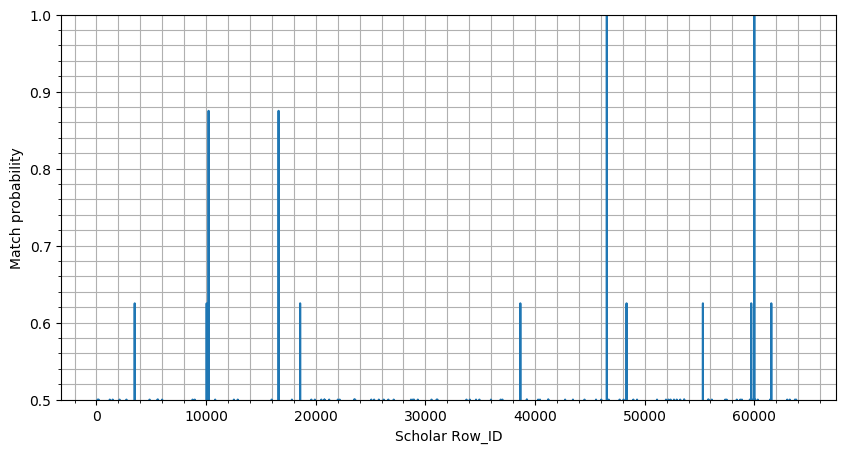

In [18]:
words = dblp.title[0].split(' ')
print(words)
words = [w for w in words if len(w) >= 3]
print(words)

p = scholar.title.str.count('|'.join(words), re.IGNORECASE) / len(words)
fig, ax = plt.subplots(1, 1)
ax.plot(scholar.ROW_ID.T, p)
ax.minorticks_on()
ax.grid(True, which='both')
ax.set_xlabel('Scholar Row_ID')
ax.set_ylabel('Match probability')
ax.set_ylim([.5,1])
print('Matches found at:')
display(scholar.loc[p==1,:])

From the above graphs, it is clear that the results from this approach match with the manual string search above. Let us try manually a couple more

In [19]:
def approach1(df1, df2, idx=0):
    words = df1.title[idx].split(' ')
    words = [w for w in words if len(w) >= 3]
    
    p = df2.title.str.count('|'.join(words), re.IGNORECASE) / len(words)
    
    return df2.loc[p==1,:]

In [20]:
for i in range(1,dblp.shape[0]):
    result = approach1(dblp, scholar, i)
    if result.shape[0] > 1:
        break
print('i = %d' % i)
display(result)

i = 3


idScholar  \
2222                                   ntqMqfgRXM4J   
5264   url:http://www.roc.noaa.gov/news/vol1is4.pdf   
6327                                   TUOBVMb4PBsJ   
16291                                  vgcXH5aVpdgJ   
22821                                  _SsvlmhsusEJ   
25454      url:http://doi.wiley.com/10.1002/tl.7700   
29706                                  skOc65LTInYJ   
31205                                  xgdBJbatYcIJ   
33893                                  p0QHT_9_NSkJ   
36301                                  hAuEDElSa2MJ   
38666                                  zMW_rq3S6VgJ   
50884                                  dO8czlfdENQJ   
53050                                  _cil6uzFNtsJ   
61808      url:http://doi.wiley.com/10.1002/ev.1658   

                                               title              authors  \
2222                                  Editor's Notes          R Goldstein   
5264                                  Editor's notes             NL Smith   
6327                                  Editor's Notes            DW Leslie   
16291                                 Editor's notes             TW Banta   
22821                                 Editor's Notes              JA Neff   
25454                                 Editor's Notes        SM Richardson   
29706                                 Editor's notes               R Diem   
31205                                 Editor's notes          WMK Trochim   
33893                                 Editor's notes   DJ Rog, D Fournier   
36301  Notes on Formalizing Context (Expanded Notes)  J McCarthy, S Buvac   
38666                                 Editor's Notes              TE Cyrs   
50884                                 Editor's notes           RH Silkman   
53050                                 EDITOR'S NOTES           SB Merriam   
61808                                 Editor's notes           L Sechrest   

                                                   venue    year  ROW_ID  
2222                          The American Statistician,  1996.0    2223  
5264              New Directions for Program Evaluation,  1981.0    5265  
6327                New Directions for Higher Education,     NaN    6328  
16291  Implementing outcomes assessment: Promise and ...     NaN   16292  
22821                               Journal of Emergency     NaN   22822  
25454          New Directions for Teaching and Learning,  1999.0   25455  
29706              Social Studies and the Young Learner,     NaN   29707  
31205             New Directions for Program Evaluation,     NaN   31206  
33893             New Directions for Program Evaluation,     NaN   33894  
36301  Technical Report CS-TN-94-13, Stanford Univers...     NaN   36302  
38666          New Directions for Teaching and Learning,     NaN   38667  
50884             New Directions for Program Evaluation,     NaN   50885  
53050  New Directions for Adult and Continuing Educat...     NaN   53051  
61808             New Directions for Program Evaluation,  1993.0   61809

This result is obviously not expected. This means that an additional filter is required - maybe authors. Let us update the function

["Editor's", 'Notes']
["Editor's", 'Notes']
['L', 'Liu']
['Liu']


Text(0,0.5,'Match probability')

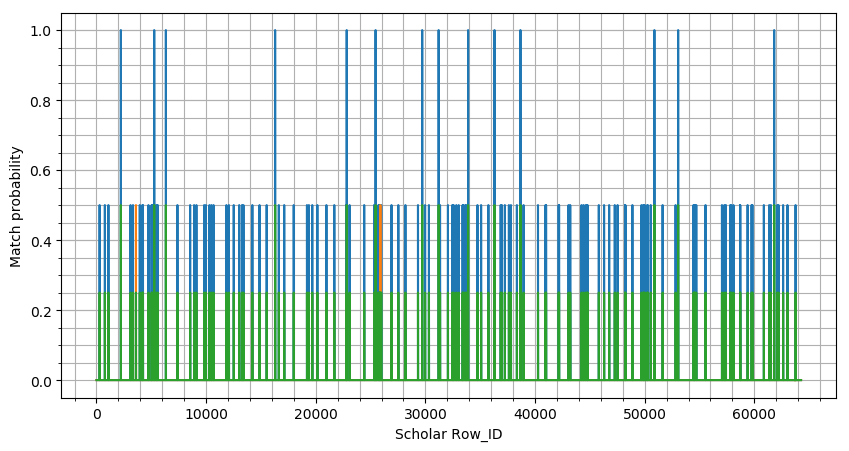

In [21]:
idx = 3
words = dblp.title[idx].split(' ')
print(words)
words = [w for w in words if len(w) >= 3]
print(words)
p1 = scholar.title.str.count('|'.join(words), re.IGNORECASE) / len(words)

authors = dblp.authors[idx].split(' ')
print(authors)
authors = [w for w in authors if len(w) >= 3]
print(authors)
p2 = scholar.authors.str.count('|'.join(words), re.IGNORECASE) / len(words)

p3 = (p1 + p2) * 0.5

fig, ax = plt.subplots(1, 1)
ax.plot(scholar.ROW_ID.T, p1, scholar.ROW_ID.T, p2, scholar.ROW_ID.T, p3)
ax.minorticks_on()
ax.grid(True, which='both')
ax.set_xlabel('Scholar Row_ID')
ax.set_ylabel('Match probability')
# ax.set_ylim([.5,1])
# print('Matches found at:')
# display(scholar.loc[p==1,:])

We thus see that `p2` and hence `p3` are much less and result in **0** matches. This is true and approach needs to be validated. We will retest the algorithm with the first row of `dblp` dataframe

idDBLP                          conf/vldb/RusinkiewiczKTWM95
title      Towards a Cooperative Transaction Model - The ...
authors     M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth
venue                                                   VLDB
year                                                    1995
Row_ID                                                     1
Name: 0, dtype: object

['Towards', 'a', 'Cooperative', 'Transaction', 'Model', '-', 'The', 'Cooperative', 'Activity', 'Model']
['Towards', 'Cooperative', 'Transaction', 'Model', 'The', 'Cooperative', 'Activity', 'Model']
['M Rusinkiewicz', ' W Klas', ' T Tesch', ' J W\x8asch', ' P Muth']
['M Rusinkiewicz', ' W Klas', ' T Tesch', ' J W\x8asch', ' P Muth']


idScholar                                              title  \
10224  019zSr3Lx4EJ  Towards a cooperative activity model-the coope...   
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   
59993  iWNLOYCQX-YJ  W asch, J., Muth, P.: Towards a cooperative tr...   

                                                 authors  \
10224   M Rusinkiewicz, W Klas, T Tesch, J Wasch, P Muth   
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   
59993                    M Rusinkiewicz, W Klas, T Tesch   

                                                   venue    year  ROW_ID  
10224  Proceedings of the 21st International Conferen...     NaN   10225  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547  
59993  Proc. ofthe 21 stInternational Conference on V...     NaN   59994

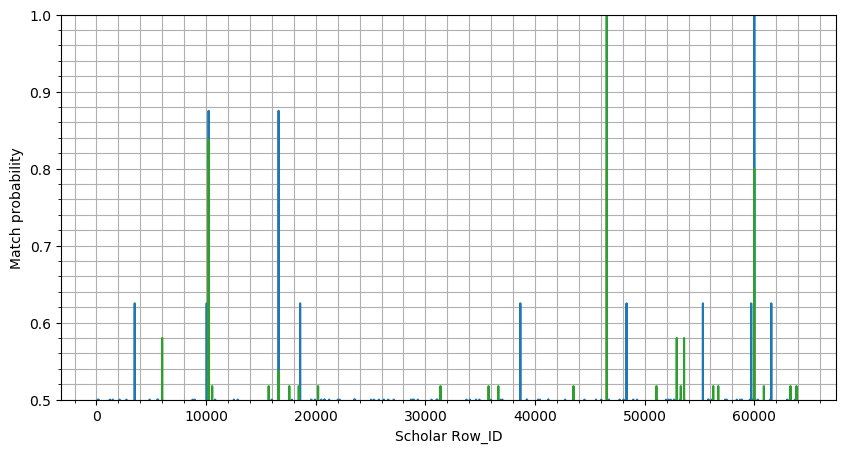

In [22]:
idx = 0
display(dblp.loc[idx,:])
words = dblp.title[idx].split(' ')
print(words)
words = [w for w in words if len(w) >= 3]
print(words)
p1 = scholar.title.str.count('|'.join(words), re.IGNORECASE) / len(words)

try:
    authors1 = dblp.authors[idx].split(',')
except Exception as e:
    logging.warning('Unable to get authors list in df2\n{}'.format(e))
    del p2
else:
    authors = authors1 #[]
#     for a in authors1:
#         authors += a.split(',')
    print(authors)
    authors = [w for w in authors if len(w) >= 3]
    print(authors)
    p2 = scholar.authors.str.count('|'.join(authors), re.IGNORECASE | re.ASCII) / len(authors)

year = dblp.year[idx]
p3 = (scholar.year == year).values * 0.33

if 'p2' in locals():
    p3 += (p1 + p2) * 0.5
else:
    p3 += p1

fig, ax = plt.subplots(1, 1)
ax.plot(scholar.ROW_ID.T, p1, label='p1')
ax.plot(scholar.ROW_ID.T, p2, label='p2')
ax.plot(scholar.ROW_ID.T, p3, label='p3')
ax.minorticks_on()
ax.grid(True, which='both')
ax.set_xlabel('Scholar Row_ID')
ax.set_ylabel('Match probability')
ax.set_ylim([.5,1])
# print('Matches found at:')
display(scholar.loc[(p3 >= .8),:])

From this graph, we can make the following observations:

1. combination required us to loosen the acceptance threshold to 80%
2. doing so revealed two new matches
3. only of the two new matches had acceptable threshold

The matching algorithm failed for the fourth match because of spelling errors in the names. We will also include year comparison in the search.

In [23]:
def approach1(df1, df2, idx=0):
    words = df1.title[idx].split(' ')
    words = [w for w in words if len(w) >= 3]
    
    p1 = df2.title.str.count('|'.join(words), re.IGNORECASE) / len(words)
    
    try:
        authors = df1.authors[idx].split(',')
    except Exception as e:
        logging.warning('Unable to get authors list in df2\n{}'.format(e))
    else:
#         authors = []
#         for a in authors1:
#             authors += a.split(',')
#         authors = [w for w in authors if len(w) >= 3]
        p2 = df2.authors.str.count('|'.join(authors), re.IGNORECASE) / len(authors)
        
    year = df1.year[idx]
    p3 = (df2.year == year).values * 0.33

    if 'p2' in locals():
        p3 += (p1 + p2) * 0.5
    else:
        p3 += p1
    
    return df2.loc[(p3 >= .8),:]

In [24]:
for i in range(1,5):#dblp.shape[0]):
    print('i = %d' % i)
    result = approach1(dblp, scholar, i)
#     if result.shape[0] > 0:
#         break
    if result.shape[0] == 0:
        continue
    display(dblp.loc[i])
    display(result)

i = 1


idDBLP        journals/sigmod/EisenbergM02
title      SQL/XML is Making Good Progress
authors              A Eisenberg, J Melton
venue                        SIGMOD Record
year                                  2002
Row_ID                                   2
Name: 1, dtype: object

idScholar                            title                authors  \
23641  6uelfg3RgEoJ          An Early Look at XQuery  A Eisenberg, J Melton   
63689  wgK6p4mDSIMJ  SQL/XML is Making Good Progress  A Eisenberg, J Melton   

                venue    year  ROW_ID  
23641  SIGMOD Record,  2002.0   23642  
63689  SIGMOD Record,  2002.0   63690

i = 2


idDBLP                                  conf/vldb/AmmannJR95
title      Using Formal Methods to Reason about Semantics...
authors                           P Ammann, S Jajodia, I Ray
venue                                                   VLDB
year                                                    1995
Row_ID                                                     3
Name: 2, dtype: object

idScholar                                              title  \
21170  x-H7BqZ0Hw8J  Using Formal Methods to Reason about Semantics...   

                          authors  \
21170  P Ammann, S Jajodia, I Ray   

                                                   venue    year  ROW_ID  
21170  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   21171

i = 3
i = 4


2018-03-28 17:49:59.750; WARNING; approach1:10; Unable to get authors list in df2
'float' object has no attribute 'split'


idDBLP                              journals/sigmod/Hammer02
title      Report on the ACM Fourth International Worksho...
authors                                                  NaN
venue                                                    NaN
year                                                    2002
Row_ID                                                     5
Name: 4, dtype: object

idScholar  \
4974  url:http://portal.acm.org/ft_gateway.cfm%3Fid%...   

                                                  title   authors  \
4974  Report on the ACM Fourth International Worksho...  J Hammer   

               venue    year  ROW_ID  
4974  SIGMOD Record,  2002.0    4975

This approach clearly works great but not quite perfect. In order to have word play, we must implement Natural Language Processing (NLP) along with the above insights.

## Approach 2 - Approach 1 + NLP
We will use the simpler NLP interface provided by the package `fuzzywuzzy`. 

idDBLP                          conf/vldb/RusinkiewiczKTWM95
title      Towards a Cooperative Transaction Model - The ...
authors     M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth
venue                                                   VLDB
year                                                    1995
Row_ID                                                     1
Name: 0, dtype: object

idScholar                                              title  \
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   

                                                 authors  \
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   

                                                   venue    year  ROW_ID  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547

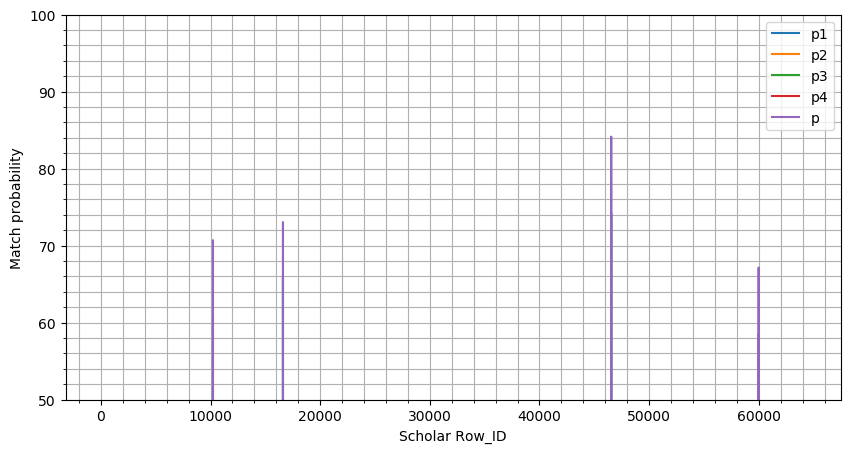

In [25]:
idx = 0
display(dblp.loc[idx,:])
title = dblp.title.values[idx]
p1 = scholar.title.apply(lambda t: fuzz.ratio(t, title)).values

author = dblp.authors.values[idx]
venue = dblp.venue.values[idx]

p2, p3 = [], []
for _, row in scholar.iterrows():
    try:
        p = fuzz.partial_token_sort_ratio(row['authors'], author)
    except Exception as e:
        p2.append(0)
    else:
        p2.append(p)

    try:
        p = fuzz.ratio(row['venue'], venue)
    except Exception as e:
        p3.append(0)
    else:
        p3.append(p)

p2 = np.array(p2)
p3 = np.array(p3)

year = dblp.year[idx]
p4 = (scholar.year == year).values * 1.0

p1 = p1 * 0.75
p2 = p2 * 0.10
p3 = p3 * 0.05
p4 = p4 * 0.10

p = p1 + p2 + p3 + p4

fig, ax = plt.subplots(1, 1)
ax.plot(scholar.ROW_ID.T, p1, label='p1')
ax.plot(scholar.ROW_ID.T, p2, label='p2')
ax.plot(scholar.ROW_ID.T, p3, label='p3')
ax.plot(scholar.ROW_ID.T, p4, label='p4')
ax.plot(scholar.ROW_ID.T, p, label='p')
ax.minorticks_on()
ax.grid(True, which='both')
ax.set_xlabel('Scholar Row_ID')
ax.set_ylabel('Match probability')
ax.legend()
ax.set_ylim([50,100])
# print('Matches found at:')
display(scholar.loc[(p >= 80),:])

In [26]:
def approach2(df1, df2, idx=0):
    title = df1.title.values[idx]
    p1 = df2.title.apply(lambda t: fuzz.partial_ratio(t, title))

    author = df1.authors.values[idx]
    venue = df1.venue.values[idx]

    p2, p3 = [], []
    for _, row in df2.iterrows():
        try:
            p = fuzz.partial_ratio(row['authors'], author)
        except Exception as e:
            p2.append(0)
        else:
            p2.append(p)
        
        try:
            p = fuzz.partial_ratio(row['venue'], venue)
        except Exception as e:
            p3.append(0)
        else:
            p3.append(p)

    p2 = np.array(p2)
    p3 = np.array(p3)

    year = df1.year[idx]
    p4 = (scholar.year == year).values * 1.0

    p1 = p1 * 0.80
    p2 = p2 * 0.10
    p3 = p3 * 0.05
    p4 = p4 * 0.05

    p = p1 + p2 + p3 + p4

    return df2.loc[(p >= 80),:]

In [27]:
for i in range(5):#dblp.shape[0]):
    print('i = %d' % i)
    result = approach2(dblp, scholar, i)
#     if result.shape[0] > 0:
#         break
    if result.shape[0] == 0:
        continue
    display(dblp.loc[i])
    display(result)

i = 0


idDBLP                          conf/vldb/RusinkiewiczKTWM95
title      Towards a Cooperative Transaction Model - The ...
authors     M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth
venue                                                   VLDB
year                                                    1995
Row_ID                                                     1
Name: 0, dtype: object

idScholar                                              title  \
12335  Z_g8bBtjKygJ                                                      
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   
59993  iWNLOYCQX-YJ  W asch, J., Muth, P.: Towards a cooperative tr...   

                                                 authors  \
12335                                             M Barr   
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   
59993                    M Rusinkiewicz, W Klas, T Tesch   

                                                   venue    year  ROW_ID  
12335                                                NaN  1979.0   12336  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547  
59993  Proc. ofthe 21 stInternational Conference on V...     NaN   59994

i = 1


idDBLP        journals/sigmod/EisenbergM02
title      SQL/XML is Making Good Progress
authors              A Eisenberg, J Melton
venue                        SIGMOD Record
year                                  2002
Row_ID                                   2
Name: 1, dtype: object

idScholar                            title                authors  \
12335  Z_g8bBtjKygJ                                                  M Barr   
56489  MY3eoV4BuDIJ                             Good    RF Goodwin, W James   
63689  wgK6p4mDSIMJ  SQL/XML is Making Good Progress  A Eisenberg, J Melton   

                                                   venue    year  ROW_ID  
12335                                                NaN  1979.0   12336  
56489  &hellip;  Two Small Communities Waterfronts: A...     NaN   56490  
63689                                     SIGMOD Record,  2002.0   63690

i = 2


idDBLP                                  conf/vldb/AmmannJR95
title      Using Formal Methods to Reason about Semantics...
authors                           P Ammann, S Jajodia, I Ray
venue                                                   VLDB
year                                                    1995
Row_ID                                                     3
Name: 2, dtype: object

idScholar                                              title  \
12335  Z_g8bBtjKygJ                                                      
21170  x-H7BqZ0Hw8J  Using Formal Methods to Reason about Semantics...   

                          authors  \
12335                      M Barr   
21170  P Ammann, S Jajodia, I Ray   

                                                   venue    year  ROW_ID  
12335                                                NaN  1979.0   12336  
21170  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   21171

i = 3


idDBLP     journals/sigmod/Liu02
title             Editor's Notes
authors                    L Liu
venue              SIGMOD Record
year                        2002
Row_ID                         4
Name: 3, dtype: object

idScholar           title  \
2222                                   ntqMqfgRXM4J  Editor's Notes   
5264   url:http://www.roc.noaa.gov/news/vol1is4.pdf  Editor's notes   
6327                                   TUOBVMb4PBsJ  Editor's Notes   
12335                                  Z_g8bBtjKygJ                   
22821                                  _SsvlmhsusEJ  Editor's Notes   
25454      url:http://doi.wiley.com/10.1002/tl.7700  Editor's Notes   
38666                                  zMW_rq3S6VgJ  Editor's Notes   

             authors                                      venue    year  \
2222     R Goldstein                 The American Statistician,  1996.0   
5264        NL Smith     New Directions for Program Evaluation,  1981.0   
6327       DW Leslie       New Directions for Higher Education,     NaN   
12335         M Barr                                        NaN  1979.0   
22821        JA Neff                       Journal of Emergency     NaN   
25454  SM Richardson  New Directions for Teaching and Learning,  1999.0   
38666        TE Cyrs  New Directions for Teaching and Learning,     NaN   

       ROW_ID  
2222     2223  
5264     5265  
6327     6328  
12335   12336  
22821   22822  
25454   25455  
38666   38667

i = 4


idDBLP                              journals/sigmod/Hammer02
title      Report on the ACM Fourth International Worksho...
authors                                                  NaN
venue                                                    NaN
year                                                    2002
Row_ID                                                     5
Name: 4, dtype: object

idScholar  \
4974   url:http://portal.acm.org/ft_gateway.cfm%3Fid%...   
12335                                       Z_g8bBtjKygJ   

                                                   title   authors  \
4974   Report on the ACM Fourth International Worksho...  J Hammer   
12335                                                       M Barr   

                venue    year  ROW_ID  
4974   SIGMOD Record,  2002.0    4975  
12335             NaN  1979.0   12336

## Approach 3 - Modified Approach 2
In approach 2, we notice that the scaling factors for each of the matching feature needs to be arbitrarily tweaked. Instead, in this approach, we will create a new sentence combining the three and find a combined score from the fuzzywuzzy partial matching algorithm.
During testing and verification, it was observed that due to the amount of inconsistencies in the dataset, the standard [*Levenshtein distance*](https://en.wikipedia.org/wiki/Levenshtein_distance) computation is in itself unreliable. *Levenshtein distance* is a metric for differences between two strings or words (aka *tokens*). It was observed that the mean of scores for string matching and token matching provided with the best metric for identifying the true matches and contrasting with the incorrect matches.

idDBLP                          conf/vldb/RusinkiewiczKTWM95
title      Towards a Cooperative Transaction Model - The ...
authors     M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth
venue                                                   VLDB
year                                                    1995
Row_ID                                                     1
Name: 0, dtype: object

Towards a Cooperative Transaction Model - The Cooperative Activity Model. M Rusinkiewicz, W Klas, T Tesch, J Wsch, P Muth. VLDB. 1995.
max: 86.50	 std: 3.26	 threshold: 76.71


idScholar                                              title  \
46546  T2fm7Wb1ak4J  Towards a Cooperative Transaction Model-The Co...   
59993  iWNLOYCQX-YJ  W asch, J., Muth, P.: Towards a cooperative tr...   

                                                 authors  \
46546  M Rusinkiewicz, W Klas, T Tesch, J Waesch, P Muth   
59993                    M Rusinkiewicz, W Klas, T Tesch   

                                                   venue    year  ROW_ID  
46546  PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON...  1995.0   46547  
59993  Proc. ofthe 21 stInternational Conference on V...     NaN   59994

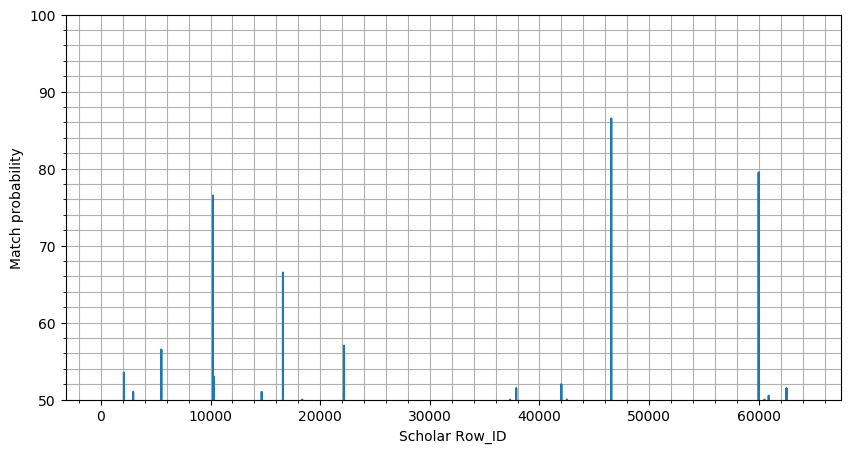

In [28]:
idx = 0
display(dblp.loc[idx,:])
title = dblp.title.values[idx]
author = dblp.authors.values[idx]
venue = dblp.venue.values[idx]
year = dblp.year.values[idx]
txt_reference = '{}. {}. {}. {:.0f}.'.format(title, author, venue, year)
print(txt_reference)

def txt_compare(row, txt_ref):
    txt_cmp = '{}. {}. {}. {:.0f}.'.format(row['title'], row['authors'], row['venue'], row['year'])

    try:
        pp = fuzz.token_set_ratio(txt_cmp, txt_ref)
        pp += fuzz.ratio(txt_cmp, txt_ref)
    except Exception as e:
        return 0
    else:
        return pp * 0.5

# p = []
# for _, row in scholar.iterrows():
# #     title = row['title']
# #     author = row['authors']
# #     venue = row['venue']
# #     year = row['year']
#     txt_cmp = '{}. {}. {}. {}.'.format(row['title'], row['authors'], row['venue'], row['year'])

#     try:
#         pp = fuzz.fuzz.partial_ratio(txt_cmp, txt_reference)
#     except Exception as e:
#         p.append(0)
#     else:
#         p.append(pp)

p, idx = [0.0] * scholar.shape[0], 0
with mp.Pool(mp.cpu_count()-1) as pool:
    for pp in pool.imap(
        partial(txt_compare, txt_ref=txt_reference), 
        [row for _, row in scholar.iterrows()],
        chunksize=1000
    ):
        p[idx] = pp
        idx += 1
p = np.array(p)

num_std = 3

print('max: {:.2f}\t std: {:.2f}\t threshold: {:.2f}'.format(p.max(), p.std(), p.max()-p.std()*num_std))

fig, ax = plt.subplots(1, 1)
ax.plot(scholar.ROW_ID.T, p, label='p')
ax.minorticks_on()
ax.grid(True, which='both')
ax.set_xlabel('Scholar Row_ID')
ax.set_ylabel('Match probability')
# ax.legend()
ax.set_ylim([50,100])
# print('Matches found at:')
display(scholar.loc[(p >= (p.max() - (p.std()*num_std))) & (p.max() > 80),:])

In [40]:
def txt_compare(row, txt_ref):
    """
    Helper function to obtain 
    """
    txt_cmp = '{}. {}. {}. {:.0f}.'.format(row['title'], row['authors'], row['venue'], row['year'])

    try:
        pp = fuzz.token_set_ratio(txt_cmp, txt_ref) 
        pp += fuzz.partial_ratio(txt_cmp, txt_ref)
    except Exception as e:
        return 0
    else:
        return pp * 0.5

def approach3(df1, df2, idx=0, threshold=3, plot=True):
    title = df1.title.values[idx]
    author = df1.authors.values[idx]
    venue = df1.venue.values[idx]
    year = df1.year.values[idx]
    txt_reference = '{}. {}. {}. {:.0f}.'.format(title, author, venue, year)
    if plot:
        print(txt_reference)
    
#     p, idx = [0.0] * df2.shape[0], 0
    with mp.Pool(mp.cpu_count()) as pool:
        p = pool.map(
            partial(txt_compare, txt_ref=txt_reference), 
            [row for _, row in df2.iterrows()],
            chunksize=1000
        )
#         for pp in pool.imap(
#             partial(txt_compare, txt_ref=txt_reference), 
#             [row for _, row in df2.iterrows()],
#             chunksize=500
#         ):
#             p[idx] = pp
#             idx += 1

    p = np.array(p)
    if plot:
        print('max: {:.2f}\t std: {:.2f}\t threshold: {:.2f}'.format(p.max(), p.std(), p.max()-p.std()*threshold))

    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(scholar.ROW_ID.T, p, label='p')
        ax.minorticks_on()
        ax.grid(True, which='both')
        ax.set_xlabel('Scholar Row_ID')
        ax.set_ylabel('Match probability')
    #     ax.legend()
        ax.set_ylim([50,100])

    return df2.loc[(p >= (p.max() - (threshold*p.std()) )) & (p.max() > 80),:]

In [30]:
ipywidgets.interact(approach3, df1=ipywidgets.fixed(dblp), df2=ipywidgets.fixed(scholar), idx = range(dblp.shape[0]), threshold=range(1,100))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 8

<function __main__.approach3>

# Create a merged result dataframe

In [82]:
dblp_scholar = pd.DataFrame(columns=['idDBLP', 'idScholar', 'DBLP_Match', 'Scholar_Match', 'Match_ID'])

In [52]:
idx = 0
dblp_row = dblp.loc[idx, ['idDBLP', 'Row_ID']]
dblp_row = pd.DataFrame(dblp_row).transpose()
dblp_row.rename(columns={'Row_ID': 'DBLP_Match'}, inplace=True)
%time sch_match = approach3(dblp, scholar, plot=False)
sch_match.drop(columns=['title','authors','venue','year'], inplace=True)
sch_match.rename(columns={'ROW_ID': 'Scholar_Match'}, inplace=True)

/Users/kvedala/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


CPU times: user 8.5 s, sys: 314 ms, total: 8.82 s
Wall time: 29.9 s


/Users/kvedala/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kvedala/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [105]:
display(scholar.shape)
for _, sch_match_row in sch_match.iterrows():
    print(sch_match_row)
    print({
        'idDBLP'        : dblp_row['idDBLP'].values[0], 
        'idScholar'     : sch_match_row['idScholar'], 
        'DBLP_Match'    : dblp_row['DBLP_Match'].values[0], 
        'Scholar_Match' : sch_match_row['Scholar_Match'],
        'Match_ID'      : '{}_{}'.format(dblp_row['DBLP_Match'].values[0], sch_match_row['Scholar_Match'])
    })
    dblp_scholar = dblp_scholar.append([{
        'idDBLP'        : dblp_row['idDBLP'].values[0], 
        'idScholar'     : sch_match_row['idScholar'], 
        'DBLP_Match'    : dblp_row['DBLP_Match'].values[0], 
        'Scholar_Match' : sch_match_row['Scholar_Match'],
        'Match_ID'      : '{}_{}'.format(dblp_row['DBLP_Match'].values[0], sch_match_row['Scholar_Match'])
    }], ignore_index=True)
display(scholar.drop(index=sch_match.index).shape)
dblp_scholar

(64260, 6)

idScholar        T2fm7Wb1ak4J
Scholar_Match           46547
Name: 46546, dtype: object
{'idDBLP': 'conf/vldb/RusinkiewiczKTWM95', 'idScholar': 'T2fm7Wb1ak4J', 'DBLP_Match': 1, 'Scholar_Match': 46547, 'Match_ID': '1_46547'}


(64259, 6)

idDBLP     idScholar DBLP_Match Scholar_Match  \
0  conf/vldb/RusinkiewiczKTWM95  T2fm7Wb1ak4J          1         46547   

  Match_ID  
0  1_46547

In [ ]:
dblp_scholar = pd.DataFrame(columns=['idDBLP', 'idScholar', 'DBLP_Match', 'Scholar_Match', 'Match_ID'])

for idx in range(dblp.shape[0]):
    dblp_row = dblp.loc[idx, ['idDBLP', 'Row_ID']]
    dblp_row = pd.DataFrame(dblp_row).transpose()
    dblp_row.rename(columns={'Row_ID': 'DBLP_Match'}, inplace=True)
    
    %time sch_match = approach3(dblp, scholar, idx=idx, plot=False)
    sch_match.drop(columns=['title','authors','venue','year'], inplace=True)
    sch_match.rename(columns={'ROW_ID': 'Scholar_Match'}, inplace=True)
    if sch_match.empty:
        continue

    for sch_idx, sch_match_row in sch_match.iterrows():
        dblp_scholar = dblp_scholar.append([{
            'idDBLP'        : dblp_row['idDBLP'].values[0], 
            'idScholar'     : sch_match_row['idScholar'], 
            'DBLP_Match'    : dblp_row['DBLP_Match'].values[0], 
            'Scholar_Match' : sch_match_row['Scholar_Match'],
            'Match_ID'      : '{}_{}'.format(dblp_row['DBLP_Match'].values[0], sch_match_row['Scholar_Match'])
        }], ignore_index=True)
        scholar.drop(index=[sch_idx], inplace=True)

In [116]:
dblp_scholar.to_csv('DBLP_Scholar_perfectMapping_KrishnaVedala.csv', index=False)